# Analysis on 10x Xenium mouse brain (coronal) dataset

Here we present the analysis of 10x Xenium mouse brain (coronal) dataset.
The original dataset can be obtained from the 10x Dataset repository (https://www.10xgenomics.com/datasets/fresh-frozen-mouse-brain-for-xenium-explorer-demo-1-standard, Full coronal section).

In [1]:
import os
import sys
sys.path.append("../")

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import scanpy as sc

from STForte import STGraph
from STForte import STForteModel
import STForte.helper as stfhelper
from STForte.helper import save_gdata, load_gdata

from pathlib import Path
trial_name = "trial-Mouse_Brain_10x_Xenium"
trial_dir = Path().resolve() / trial_name
data_dir = Path().resolve() / ".." / "data" / "xenium"
if not os.path.exists(trial_dir):
    os.makedirs(trial_dir)

Global seed set to 0


## Data Preprocessing

We load the dataset from original files provided in the 10x Xenium Output Bundle. We filtered out low-expressed cells/genes. Then, we preprocess the count matrix with `sc.pp.normalize_total` and `sc.pp.log1p`. Since it only contains 248 genes in this in situ dataset, we use preprocessed count matrix as the expression profile input. Spatial neighbors is constructed through K nearest neighbors based on KDTree considering the efficiency.

In [2]:
adata = sc.read_10x_h5(
    filename=data_dir / "Xenium_V1_FF_Mouse_Brain_Coronal_feature_matrix.h5"
)
df = pd.read_csv(
    data_dir / "Xenium_V1_FF_Mouse_Brain_Coronal_outscells.csv"
)
df.set_index(adata.obs_names, inplace=True)
adata.obs = df.copy()
adata.obsm["spatial"] = adata.obs[["x_centroid", "y_centroid"]].copy().to_numpy()
adata

AnnData object with n_obs × n_vars = 130870 × 248
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area'
    var: 'gene_ids', 'feature_types', 'genome'
    obsm: 'spatial'

In [3]:
# QC
sc.pp.filter_cells(adata, min_counts=10)
sc.pp.filter_genes(adata, min_cells=5)
# Normalization
adata.layers['count'] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata

AnnData object with n_obs × n_vars = 130557 × 248
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'log1p'
    obsm: 'spatial'
    layers: 'count'

In [4]:
stgraph = STGraph.graphFromAnndata(adata=adata, 
                                   knn=True,  # Directly initializing knn for non-lattice data.
                                   kdtree=True,
                                   k=10)
gdata = stgraph.topyg()
print(f"The Data contians {gdata.x.size(0)} cells.")

KDTree knn innitialize.
The Data contians 130557 cells.


## Fitting STForte model
We establish the model and fit it to obtain the latent encodings. STForte was designed to handle large scale datasets through setting `partial_adjacent=True` in STForte module setting (It takes $\approx$ 8.5GB for this data, 130,870 cells).

In [5]:
model = STForteModel(
    adata=adata,
    gdata=gdata,
    epochs=500,
    output_dir=trial_dir / "pl_ckpts",
    module_kwargs=dict(partial_adjacent=True),
)
model.fit()

Global seed set to 42
/home/poncey/miniconda3/envs/stforte_env/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:474: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type              | Params
----------------------------------------------------
0 | attr_encoder  | Sequential        | 61.5 K
1 | strc_encoder  | Sequential_d64267 | 61.5 K
2 | attr_decoder  | Sequential        | 61.7 K
3 | strc_decoder  | Sequential        | 2.1 K 
4 | discriminator | Sequential        | 1.1 K 
----------------------------------------------------
187 K     Trainable params
0         Non-trainable params
187 K   

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=500` reached.


Save model and anndata/gdata outputs.

In [6]:
if not os.path.exists(trial_dir / "data"):
    os.makedirs(trial_dir / "data")
save_gdata(gdata, path=trial_dir / "data/gdata.pkl")
adata.write_h5ad(trial_dir / "data/trial.h5ad")
model.save_state_dict(trial_dir / "models", alias="STForteModel_mouse_brain_Xenium")
# For analysis in original resolution
model.get_latent_original(adata)
if not os.path.exists(trial_dir / "outputs"):
    os.makedirs(trial_dir / "outputs")
adata.write(trial_dir / "outputs/stforte.h5ad")

## Spatial region identification and Visualization

Next, we use Leiden community detection to identify spatial regions. Here, COMB encoding is used considering the anatomical region is spatially homogeneous.

In [7]:
sc.pp.neighbors(adata, use_rep='STForte_COMB')
sc.tl.leiden(adata, resolution=0.85)
sc.tl.umap(adata)

In [8]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
sc.set_figure_params(dpi=120 , fontsize=18)
plt.rcParams['font.sans-serif'] = [
    'Arial',
    'Helvetica',
    'sans-serif',]

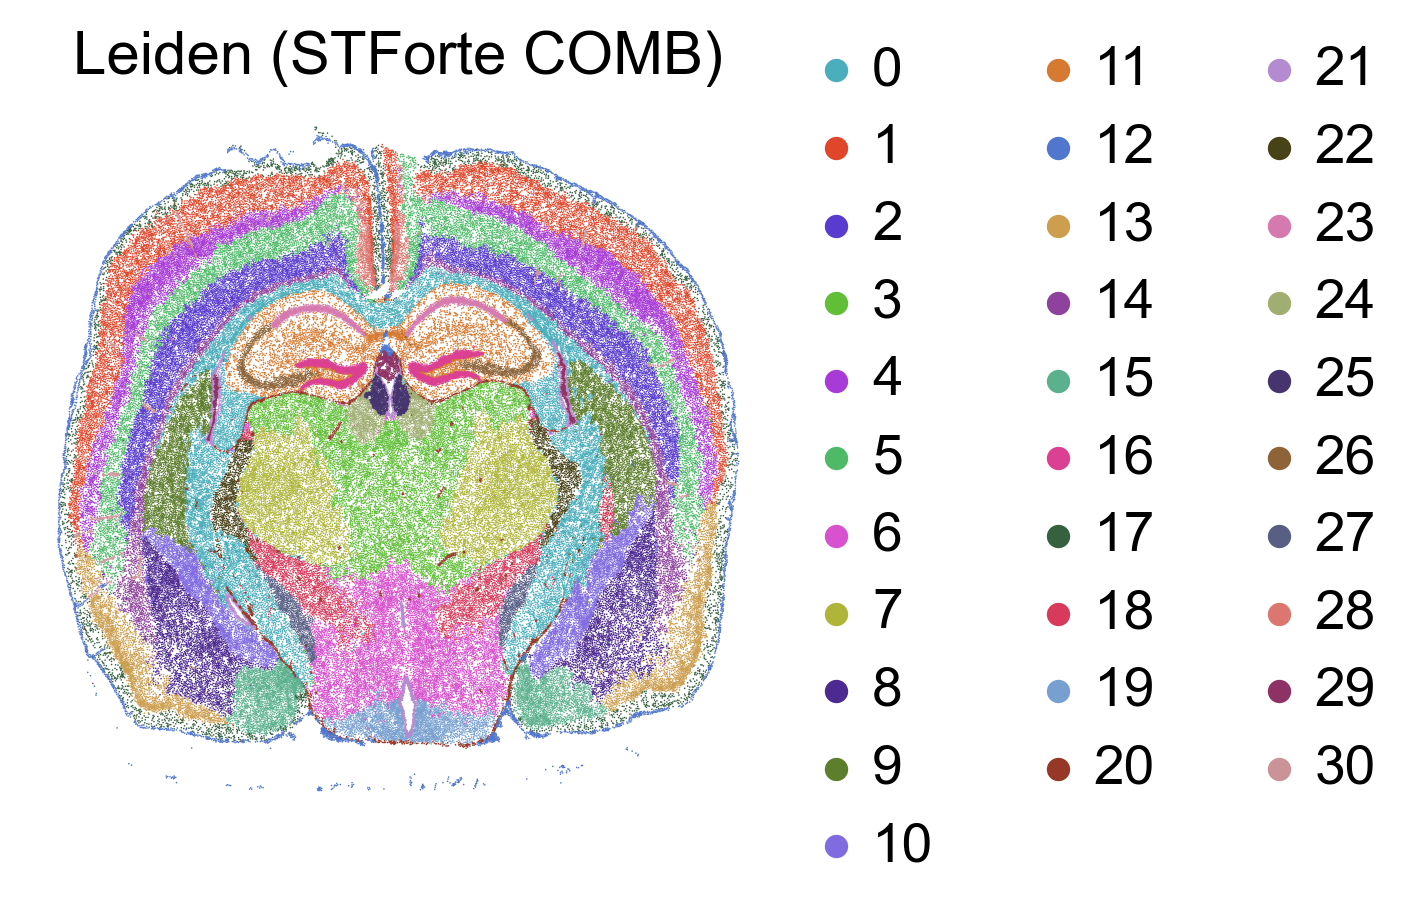

In [9]:
palette = stfhelper.pl.iwanthue_32_soft
fig, ax = plt.subplots()
coord = adata.obsm["spatial"].copy()
coord[:, 1] = -coord[:, 1]
adata.obsm["coord_section"] = coord
sc.pl.embedding(
    adata,
    basis="coord_section",
    color=["leiden"],
    title=["Leiden (STForte COMB)"],
    palette=palette,
    ax=ax,
    frameon=False,
)
ax.set_aspect(1)
plt.show()

<Axes: title={'center': 'leiden'}, xlabel='UMAP1', ylabel='UMAP2'>

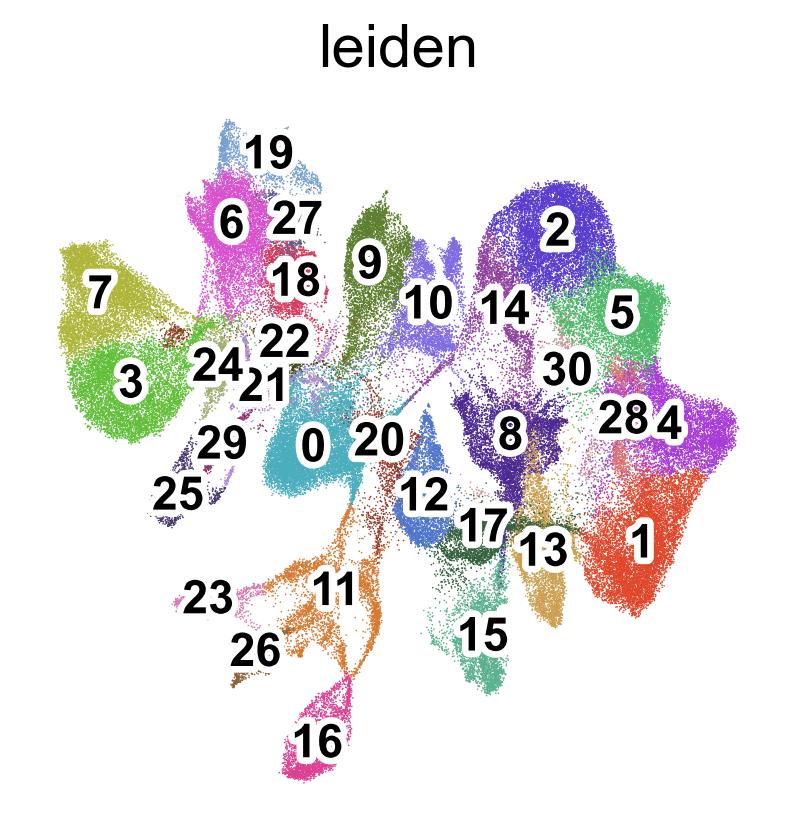

In [10]:
sc.pl.umap(
    adata,
    color=["leiden"],
    frameon=False,
    legend_loc="on data",
    legend_fontoutline=4,
    legend_fontsize=14,
    show=False,
)
